Initialize the environment

In [2]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

worker = TamGenDemo(
    data="./TamGen_Demo_Data"
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

gpt_model/checkpoint_best.pt


Set the PDB you want to generate cmpds

In [3]:
pdb_id = "7te0" # "5dzk, 7d1m" 
prepare_pdb_data(pdb_id,)
worker.reload_data(subset="gen_" + pdb_id.lower())

def customer_filter_fn_for_3um8(smi, mol):
    if "p" in smi or "P" in smi:
        return False
    return True

hyps, ref = worker.sample(
    m_sample=5000, 
    # customer_filter_fn=customer_filter_fn_for_3um8
)

7te0 is downloaded
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7te0.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7te0.tg-m1.m1
| ./TamGen_Demo_Data gen_7te0 tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7te0.tg-m1.tg.coord


  0%|          | 0/100 [00:00<?, ?it/s]/home/yinxia/workdir/submit/TamGent/fairseq/search.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.beams_buf = self.indices_buf // vocab_size
100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


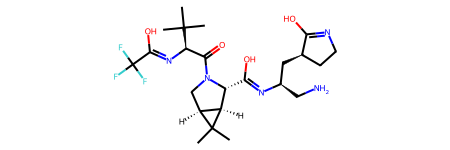

In [4]:
ref

/home/yinxia/miniconda3/envs/dd2/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


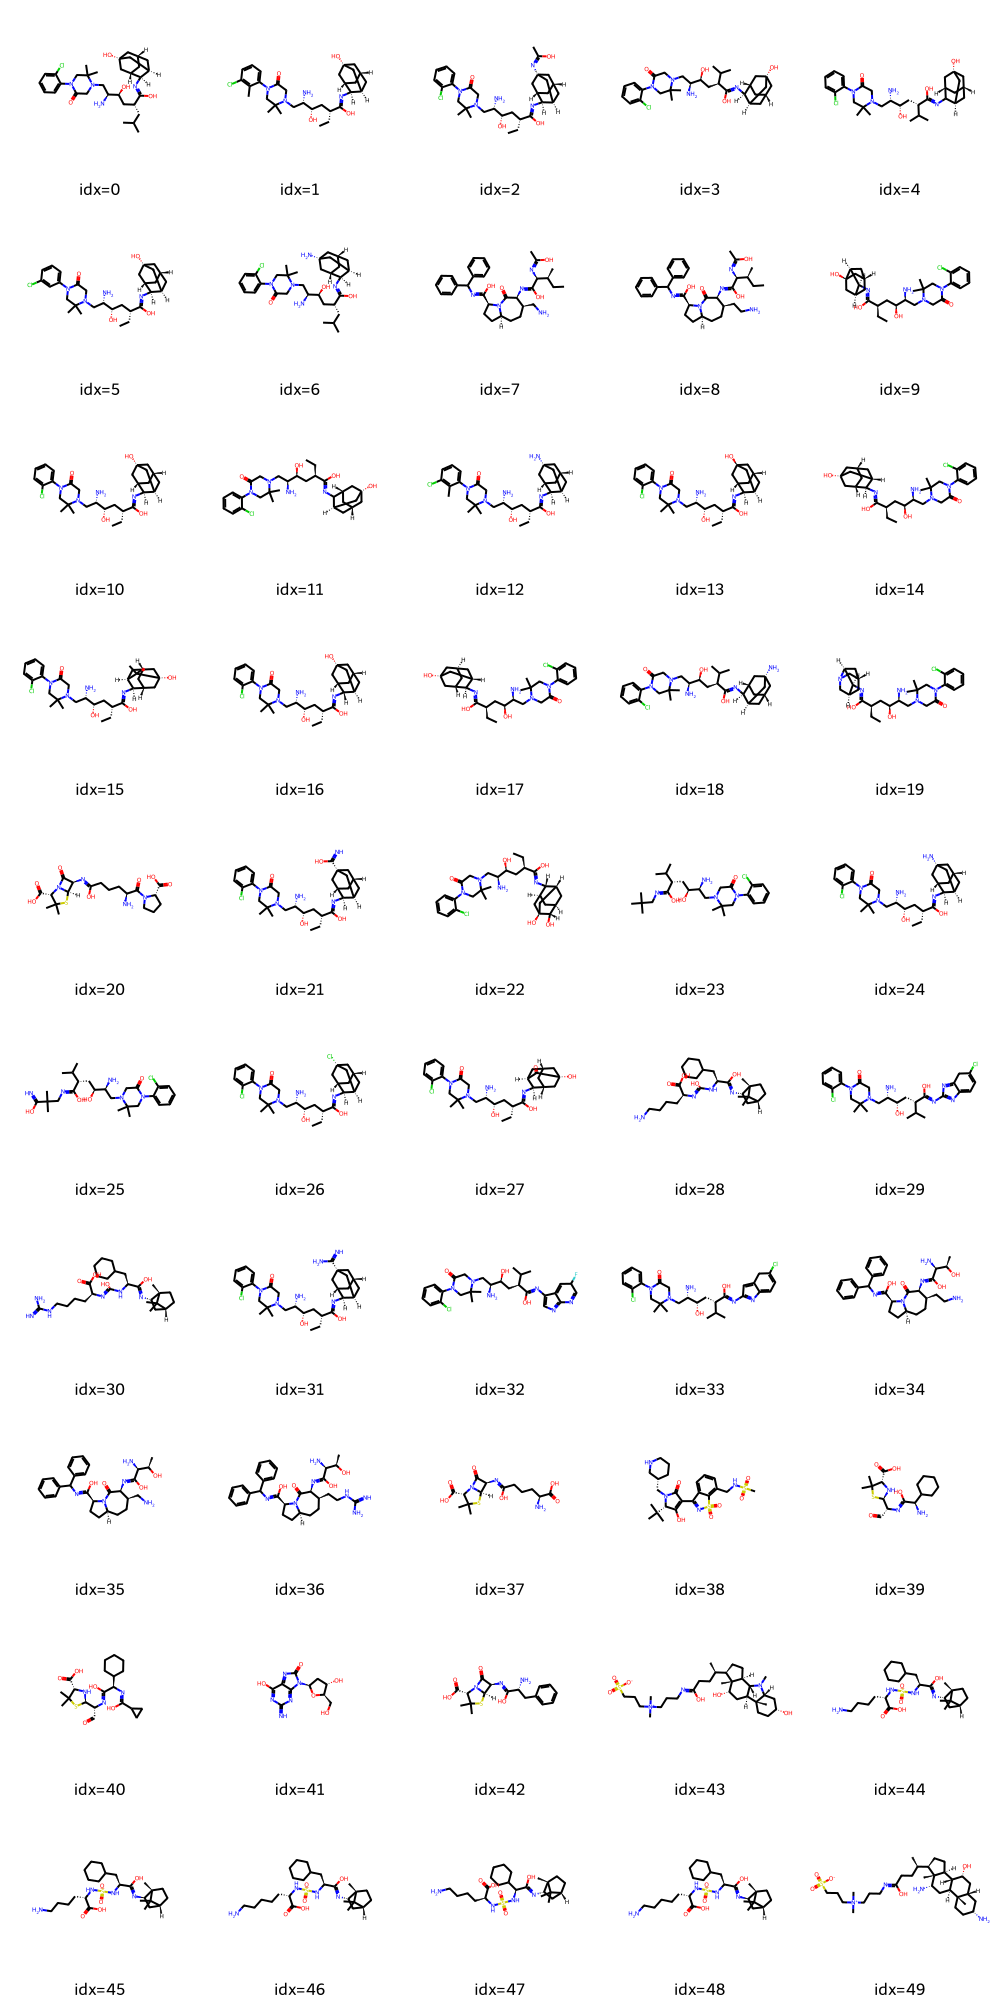

In [5]:
from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem import MACCSkeys

fp_ref = MACCSkeys.GenMACCSKeys(ref)

gens = []

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens.append((v,k, similarity))

sorted_gen = sorted(gens, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(sorted_gen))])
img